# Goal

* The qSIP results are surprisingly consistent in sensitivity.
  * Specificity is always ~80-90%
  * Checking to make sure this isn't an artifact
 

# Setting variables

In [138]:
# paths
import os

workDir1 = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/'
workDir2 = '/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/'

## Init

In [2]:
import glob
import itertools
import nestly

In [3]:
%load_ext rpy2.ipython
%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Init

# atomIncorp_taxaIncorp

In [238]:
%cd $workDir1

/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp


In [239]:
atomX_files = glob.glob('*/*/*/*_atom.txt')
len(atomX_files)

250

In [240]:
%%R -i atomX_files

df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$percIncorp = FF[1]
    tmp$percTaxa = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3)

                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017       NA  1.735000           NA
2 Acetobacter_pasteurianus_IFO_3283-03 1.711478  1.730446  0.018967947
3       Acetobacterium_woodii_DSM_1030 1.706348  1.698732 -0.007615707
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1         NA         NA               NA           NA                   NA
2  0.7834275   308.0796         317.6634     311.4940            0.3523052
3  0.7219901   308.0491         317.6636     306.6742           -0.1414111
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1          NA           NA         50       50   7
2   0.3287802   0.37572502         50       50   7
3  -0.2018421  -0.07953983         50       50   7
                              file
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3 OTU_abs1e9_PCR_sub_qSIP_atom.txt


In [241]:
BDshift_files = glob.glob('*/*/*/BD-shift_stats.txt')
len(BDshift_files)

250

In [242]:
%%R -i BDshift_files

df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$percIncorp = FF[1]
    tmp$percTaxa = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)

df_shift %>% head(n=3)

Source: local data frame [3 x 5]

                           taxon percIncorp percTaxa   rep median_true_BD_shift
                          (fctr)      (chr)    (chr) (chr)                (dbl)
1 Acaryochloris_marina_MBIC11017          0        1     1                    0
2 Acaryochloris_marina_MBIC11017          0        1    10                    0
3 Acaryochloris_marina_MBIC11017          0        1     2                    0


In [243]:
comm_files = glob.glob('*/*/*/comm.txt')
len(comm_files)

250

In [244]:
%%R -i comm_files

df_comm = list()
for(F in comm_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$percIncorp = FF[1]
    tmp$percTaxa = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_comm[[F]] = tmp
}

df_comm = do.call(rbind, df_comm)
rownames(df_comm) = 1:nrow(df_comm)

# summarize
df_comm = df_comm %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon_name, percIncorp, percTaxa, rep) %>%
    summarize(min_abund = min(rel_abund_perc, na.rm=TRUE),
              mean_abund = mean(rel_abund_perc, na.rm=TRUE),
              median_abund = median(rel_abund_perc, na.rm=TRUE),
              max_abund = max(rel_abund_perc, na.rm=TRUE),
              sd_abund = sd(rel_abund_perc, na.rm=TRUE)) %>%
    ungroup() 

# status
df_comm %>% head(n=3)

Source: local data frame [3 x 9]

                      taxon_name percIncorp percTaxa   rep  min_abund
                          (fctr)      (chr)    (chr) (chr)      (dbl)
1 Acaryochloris_marina_MBIC11017          0        1     1 0.01538821
2 Acaryochloris_marina_MBIC11017          0        1    10 0.07914670
3 Acaryochloris_marina_MBIC11017          0        1     2 0.01333922
Variables not shown: mean_abund (dbl), median_abund (dbl), max_abund (dbl),
  sd_abund (dbl)


### Joining

In [245]:
%%R

tmp = anti_join(df_atomX, df_shift,  c('taxon' = 'taxon',
                                        'percIncorp'='percIncorp',
                                        'percTaxa'='percTaxa',
                                        'rep'='rep'))
tmp %>% head

                                                       taxon control treatment
1                          Sphaerochaeta_coccoides_DSM_17374      NA        NA
2                         Prosthecochloris_aestuarii_DSM_271      NA        NA
3 Propionibacterium_freudenreichii_subsp_shermanii_CIRM-BIA1      NA        NA
4                             Propionibacterium_avidum_44067      NA        NA
5                       Pelodictyon_phaeoclathratiforme_BU-1      NA        NA
6                           Parachlamydia_acanthamoebae_UV-7      NA        NA
  BD_diff control_GC control_MW treatment_max_MW treatment_MW
1      NA         NA         NA               NA           NA
2      NA         NA         NA               NA           NA
3      NA         NA         NA               NA           NA
4      NA         NA         NA               NA           NA
5      NA         NA         NA               NA           NA
6      NA         NA         NA               NA           NA
  atom_fracti

In [246]:
%%R
# qSIP & real-shift
df_atomX %>% nrow %>% print
df.j = left_join(df_atomX, df_shift,   c('taxon' = 'taxon',
                                        'percIncorp'='percIncorp',
                                        'percTaxa'='percTaxa',
                                        'rep'='rep')) %>%
    #filter(!is.na(BD_diff)) %>%
    mutate(median_true_BD_shift = ifelse(is.na(median_true_BD_shift), 0, median_true_BD_shift),
           true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))

df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 286750
[1] 286750
                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017       NA  1.735000           NA
2 Acetobacter_pasteurianus_IFO_3283-03 1.711478  1.730446  0.018967947
3       Acetobacterium_woodii_DSM_1030 1.706348  1.698732 -0.007615707
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1         NA         NA               NA           NA            0.0000000
2  0.7834275   308.0796         317.6634     311.4940            0.3523052
3  0.7219901   308.0491         317.6636     306.6742           -0.1414111
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1          NA           NA         50       50   7
2   0.3287802   0.37572502         50       50   7
3  -0.2018421  -0.07953983         50       50   7
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                0.018              TRUE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt        

In [247]:
%%R
# qSIP & real-shift & comm
df.j %>% nrow %>% print
df.j = inner_join(df.j, df_comm, c('taxon' = 'taxon_name',
                                    'percIncorp'='percIncorp',
                                    'percTaxa'='percTaxa',
                                    'rep'='rep'))

df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 286750
[1] 286750
                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017       NA  1.735000           NA
2 Acetobacter_pasteurianus_IFO_3283-03 1.711478  1.730446  0.018967947
3       Acetobacterium_woodii_DSM_1030 1.706348  1.698732 -0.007615707
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1         NA         NA               NA           NA            0.0000000
2  0.7834275   308.0796         317.6634     311.4940            0.3523052
3  0.7219901   308.0491         317.6636     306.6742           -0.1414111
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1          NA           NA         50       50   7
2   0.3287802   0.37572502         50       50   7
3  -0.2018421  -0.07953983         50       50   7
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                0.018              TRUE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt        

In [248]:
%%R
# free memory
df_shift = df_atomX = df_comm = NULL

### qSIP atom % for 15% incorp

[1] 286750


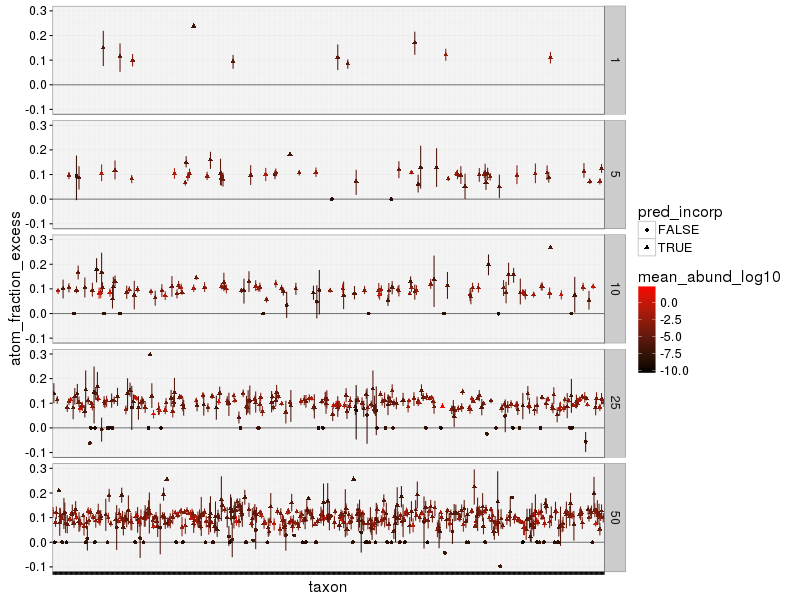

In [249]:
%%R -w 800 -h 600
as.Num = function(x) x %>% as.character %>% as.numeric

df.j %>% nrow %>% print
df.j.f = df.j %>%
    filter(percIncorp == 15, 
           rep==1,
           true_incorporator==TRUE) %>%
    mutate(atom_fraction_excess = atom_fraction_excess %>% as.Num,
           atom_CI_low = atom_CI_low %>% as.Num,
           atom_CI_high = atom_CI_high %>% as.Num,
           pred_incorp = atom_CI_low > 0,
           pred_incorp = ifelse(is.na(pred_incorp), FALSE, pred_incorp),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           mean_abund_log10 = log(mean_abund),
           atom_CI = atom_CI_high - atom_CI_low)

# plotting
ggplot(df.j.f, aes(taxon, atom_fraction_excess, 
                   ymin=atom_CI_low, ymax=atom_CI_high,
                   color=mean_abund_log10,
                   shape=pred_incorp)) +
    geom_point() +
    geom_linerange() +
    geom_hline(yintercept=0, alpha=0.5) +
    scale_color_gradient(low='black', high='red') +
    scale_y_continuous(limits=c(-0.1, 0.3)) +
    facet_grid(percTaxa ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

## CI size ~ relative abundance

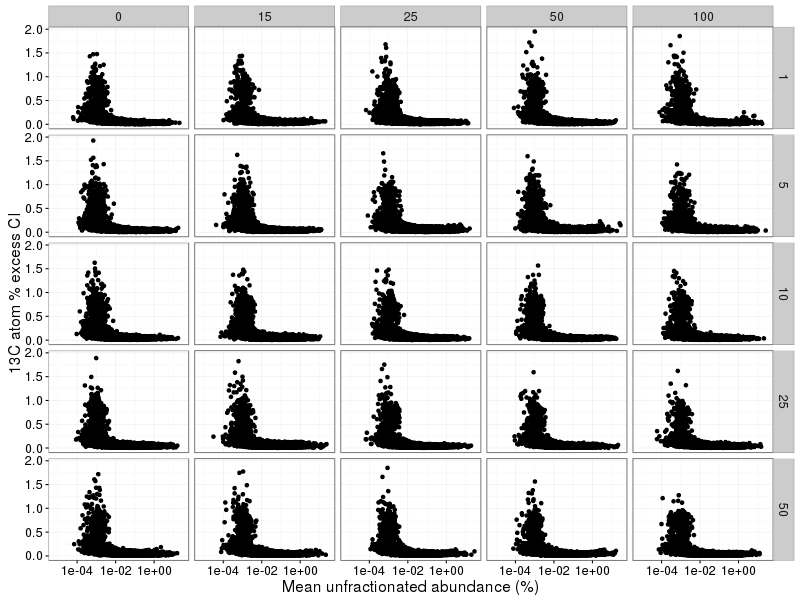

In [250]:
%%R -w 800 -h 600
as.Num = function(x) x %>% as.character %>% as.numeric

df.j.f = df.j %>%
    mutate(atom_fraction_excess = atom_fraction_excess %>% as.Num,
           atom_CI_low = atom_CI_low %>% as.Num,
           atom_CI_high = atom_CI_high %>% as.Num,
           atom_CI = atom_CI_high - atom_CI_low,
            percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric))
    
ggplot(df.j.f, aes(mean_abund, atom_CI)) +
    geom_point() +
    scale_x_log10() +
    labs(x='Mean unfractionated abundance (%)', 
         y='13C atom % excess CI') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

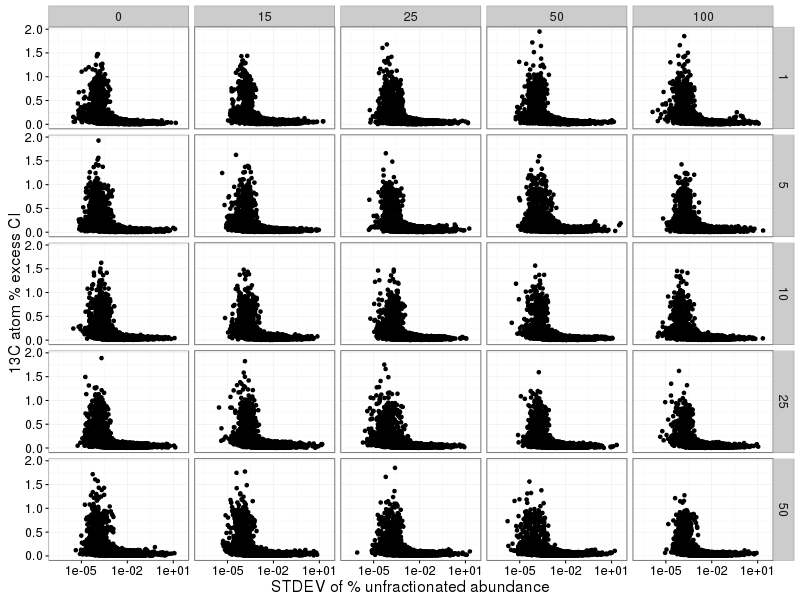

In [251]:
%%R -w 800 -h 600
as.Num = function(x) x %>% as.character %>% as.numeric

ggplot(df.j.f, aes(sd_abund, atom_CI)) +
    geom_point() +
    scale_x_log10() +
    labs(x='STDEV of % unfractionated abundance', 
         y='13C atom % excess CI') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Sensitivity/specificity

[1] 286750


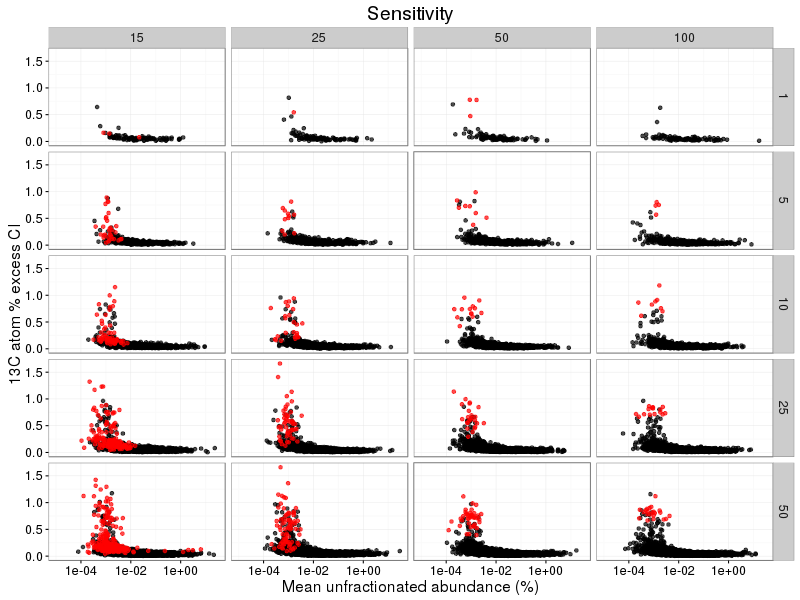

In [252]:
%%R -w 800 -h 600
as.Num = function(x) x %>% as.character %>% as.numeric

df.j %>% nrow %>% print
df.j.f = df.j %>%
    filter(true_incorporator==TRUE) %>%
    mutate(atom_fraction_excess = atom_fraction_excess %>% as.Num,
           atom_CI_low = atom_CI_low %>% as.Num,
           atom_CI_high = atom_CI_high %>% as.Num,
           pred_incorp = atom_CI_low > 0,
           pred_incorp = ifelse(is.na(pred_incorp), FALSE, pred_incorp),
           atom_CI = atom_CI_high - atom_CI_low,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric))
        
    
# plotting
ggplot(df.j.f, aes(mean_abund, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.7, color='red') +    
    scale_x_log10() +
#    scale_color_discrete('True\nincorporator?') +
    facet_grid(percTaxa ~ percIncorp) +
    labs(x='Mean unfractionated abundance (%)', 
         y='13C atom % excess CI',
         title='Sensitivity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

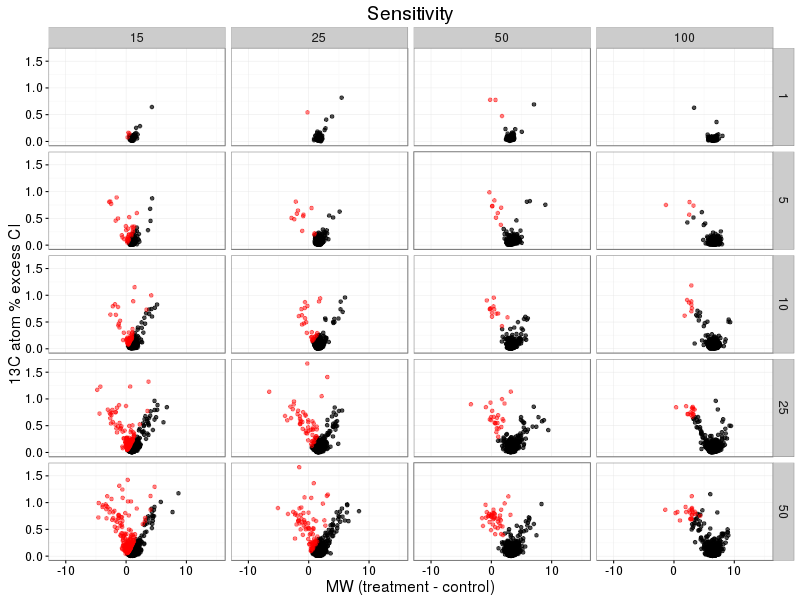

In [253]:
%%R -w 800 -h 600
    
# plotting
ggplot(df.j.f, aes(treatment_MW - control_MW, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.5, color='red') +    
    facet_grid(percTaxa ~ percIncorp) +
    labs(x='MW (treatment - control)', 
         y='13C atom % excess CI',
         title='Sensitivity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

[1] 286750


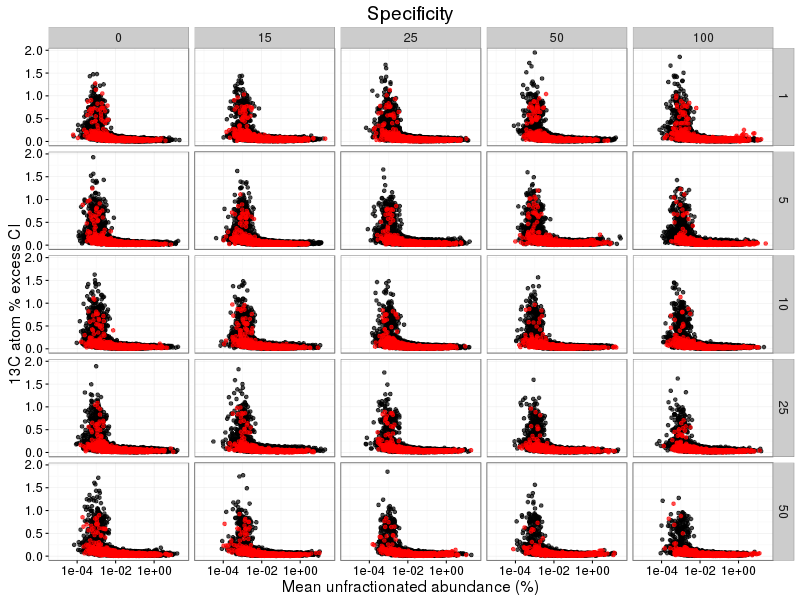

In [254]:
%%R -w 800 -h 600
as.Num = function(x) x %>% as.character %>% as.numeric

df.j %>% nrow %>% print
df.j.f = df.j %>%
    filter(true_incorporator==FALSE) %>%
    mutate(atom_fraction_excess = atom_fraction_excess %>% as.Num,
           atom_CI_low = atom_CI_low %>% as.Num,
           atom_CI_high = atom_CI_high %>% as.Num,
           pred_incorp = atom_CI_low > 0,
           pred_incorp = ifelse(is.na(pred_incorp), FALSE, pred_incorp),
           atom_CI = atom_CI_high - atom_CI_low,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric))
        
    
# plotting
ggplot(df.j.f, aes(mean_abund, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='red') +
    scale_x_log10() +
    facet_grid(percTaxa ~ percIncorp) +
    labs(x='Mean unfractionated abundance (%)', 
         y='13C atom % excess CI',
         title='Specificity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

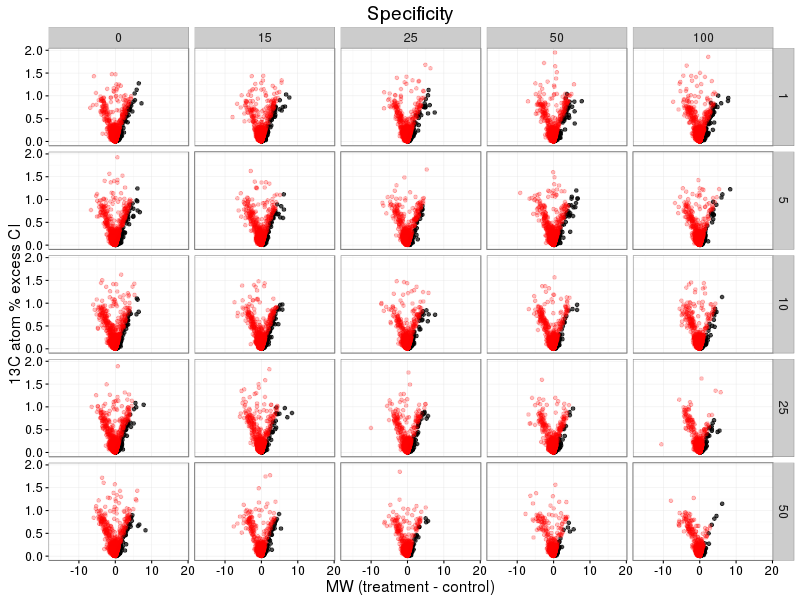

In [255]:
%%R -w 800 -h 600
    
# plotting
ggplot(df.j.f, aes(treatment_MW - control_MW, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.25, color='red') +    
    facet_grid(percTaxa ~ percIncorp) +
    labs(x='MW (treatment - control)', 
         y='13C atom % excess CI',
         title='Specificity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Number of false positives

[1] 286750


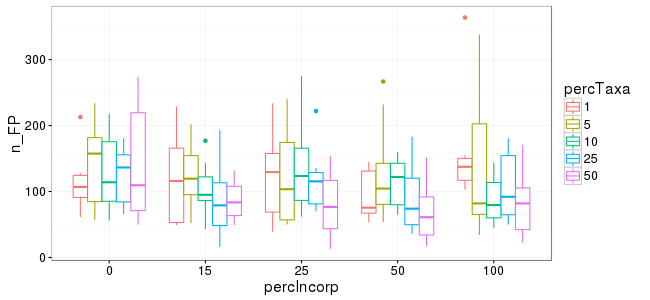

In [256]:
%%R -w 650 -h 300
as.Num = function(x) x %>% as.character %>% as.numeric

df.j %>% nrow %>% print
df.j.s = df.j %>%
    filter(true_incorporator==FALSE) %>%
    mutate(pred_incorp = atom_CI_low > 0,
           pred_incorp = ifelse(is.na(pred_incorp), FALSE, pred_incorp),
           FP = ifelse((pred_incorp==TRUE & true_incorporator==FALSE), 1, 0),
           TP = ifelse((pred_incorp==TRUE & true_incorporator==TRUE), 1, 0),
           FN = ifelse((pred_incorp==FALSE & true_incorporator==TRUE), 1, 0),
           TN = ifelse((pred_incorp==FALSE & true_incorporator==FALSE), 1, 0)) %>%
    group_by(percIncorp,percTaxa,rep) %>%
    summarize(n_FP = sum(FP),
              n_TP = sum(TP),
              n_FN = sum(FN),
              n_TN = sum(TN),
              n = n(),
              specificity = n_TN / (n_TN+n_FP),
              sensitivity = n_TP / (n_TP+n_FN)) %>%
    #group_by(percIncorp,percTaxa) %>%
    #summarize(mean_n_FP = mean(n_FP)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))

    
# plotting
ggplot(df.j.s, aes(percIncorp, n_FP, color=percTaxa)) +
    geom_boxplot() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# microBetaDiv

In [209]:
%cd $workDir2

/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv


In [210]:
atomX_files = glob.glob('*/*/*/*_atom.txt')
len(atomX_files)

400

In [211]:
%%R -i atomX_files


df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$shared_perc = FF[1]
    tmp$perm_perc = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3)

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.708033  1.709418  0.0013851679
2 Acetobacter_pasteurianus_IFO_3283-03 1.712330  1.712616  0.0002866604
3       Acetobacterium_woodii_DSM_1030 1.704179  1.703843 -0.0003364652
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7421776   308.0591         317.6635     308.3089          0.025722669
2  0.7936284   308.0846         317.6634     308.1362          0.005324613
3  0.6960235   308.0362         317.6637     307.9754         -0.006246878
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.007952873   0.05800202          80        20   7
2 -0.013487728   0.02572328          80        20   7
3 -0.025040726   0.01425911          80        20   7
                              file
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3 OTU_abs1e9_PCR_sub_qSIP_atom.txt


In [212]:
BDshift_files = glob.glob('*/*/*/BD-shift_stats.txt')
len(BDshift_files)

400

In [213]:
%%R -i BDshift_files

df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$shared_perc = FF[1]
    tmp$perm_perc = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, shared_perc, perm_perc, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)

df_shift %>% head(n=3)

Source: local data frame [3 x 5]

                           taxon shared_perc perm_perc   rep
                          (fctr)       (chr)     (chr) (chr)
1 Acaryochloris_marina_MBIC11017         100         0     1
2 Acaryochloris_marina_MBIC11017         100         0    10
3 Acaryochloris_marina_MBIC11017         100         0     2
Variables not shown: median_true_BD_shift (dbl)


In [214]:
comm_files = glob.glob('*/*/*/comm.txt')
len(comm_files)

400

In [215]:
%%R -i comm_files

df_comm = list()
for(F in comm_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$shared_perc = FF[1]
    tmp$perm_perc = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_comm[[F]] = tmp
}

df_comm = do.call(rbind, df_comm)
rownames(df_comm) = 1:nrow(df_comm)

# summarize
df_comm = df_comm %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon_name, shared_perc, perm_perc, rep) %>%
    summarize(min_abund = min(rel_abund_perc, na.rm=TRUE),
              mean_abund = mean(rel_abund_perc, na.rm=TRUE),
              median_abund = median(rel_abund_perc, na.rm=TRUE),
              max_abund = max(rel_abund_perc, na.rm=TRUE),
              sd_abund = sd(rel_abund_perc, na.rm=TRUE)) %>%
    ungroup() 

# status
df_comm %>% head(n=3)

Source: local data frame [3 x 9]

                      taxon_name shared_perc perm_perc   rep   min_abund
                          (fctr)       (chr)     (chr) (chr)       (dbl)
1 Acaryochloris_marina_MBIC11017         100         0     1 0.000311972
2 Acaryochloris_marina_MBIC11017         100         0    10 0.008512752
3 Acaryochloris_marina_MBIC11017         100         0     2 0.002689945
Variables not shown: mean_abund (dbl), median_abund (dbl), max_abund (dbl),
  sd_abund (dbl)


### Joining

In [151]:
%%R
# # qSIP & real-shift
# df_atomX %>% nrow %>% print
# df.j = inner_join(df_atomX, df_shift, c('taxon' = 'taxon',
#                                         'shared_perc'='shared_perc',
#                                         'perm_perc'='perm_perc',
#                                         'rep'='rep')) %>%
#     filter(!is.na(BD_diff)) %>%
#     mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
#            true_atom_fraction_excess = median_true_BD_shift / 0.036,
#            atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))

# df.j %>% nrow %>% print
# df.j %>% head(n=3)

[1] 441920
[1] 326984
                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.708033  1.709418  0.0013851679
2 Acetobacter_pasteurianus_IFO_3283-03 1.712330  1.712616  0.0002866604
3       Acetobacterium_woodii_DSM_1030 1.704179  1.703843 -0.0003364652
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7421776   308.0591         317.6635     308.3089          0.025722669
2  0.7936284   308.0846         317.6634     308.1362          0.005324613
3  0.6960235   308.0362         317.6637     307.9754         -0.006246878
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.007952873   0.05800202          80        20   7
2 -0.013487728   0.02572328          80        20   7
3 -0.025040726   0.01425911          80        20   7
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_

In [216]:
%%R
# qSIP & real-shift
df_atomX %>% nrow %>% print
df.j = left_join(df_atomX, df_shift, c('taxon' = 'taxon',
                                       'shared_perc'='shared_perc',
                                       'perm_perc'='perm_perc',
                                       'rep'='rep')) %>%
    #filter(!is.na(BD_diff)) %>%
    mutate(median_true_BD_shift = ifelse(is.na(median_true_BD_shift), 0, median_true_BD_shift),
           true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))

df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 441920
[1] 441920
                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.708033  1.709418  0.0013851679
2 Acetobacter_pasteurianus_IFO_3283-03 1.712330  1.712616  0.0002866604
3       Acetobacterium_woodii_DSM_1030 1.704179  1.703843 -0.0003364652
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7421776   308.0591         317.6635     308.3089          0.025722669
2  0.7936284   308.0846         317.6634     308.1362          0.005324613
3  0.6960235   308.0362         317.6637     307.9754         -0.006246878
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.007952873   0.05800202          80        20   7
2 -0.013487728   0.02572328          80        20   7
3 -0.025040726   0.01425911          80        20   7
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_

In [217]:
%%R
# qSIP & real-shift & comm
df.j %>% nrow %>% print
df.j = inner_join(df.j, df_comm, c('taxon' = 'taxon_name',
                                    'shared_perc'='shared_perc',
                                    'perm_perc'='perm_perc',
                                    'rep'='rep')) 

df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 441920
[1] 441920
                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.708033  1.709418  0.0013851679
2 Acetobacter_pasteurianus_IFO_3283-03 1.712330  1.712616  0.0002866604
3       Acetobacterium_woodii_DSM_1030 1.704179  1.703843 -0.0003364652
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7421776   308.0591         317.6635     308.3089          0.025722669
2  0.7936284   308.0846         317.6634     308.1362          0.005324613
3  0.6960235   308.0362         317.6637     307.9754         -0.006246878
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.007952873   0.05800202          80        20   7
2 -0.013487728   0.02572328          80        20   7
3 -0.025040726   0.01425911          80        20   7
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_

In [218]:
%%R
# free memory
df_shift = df_atomX = df_comm = NULL

## Assesing accuracy 

[1] 441920


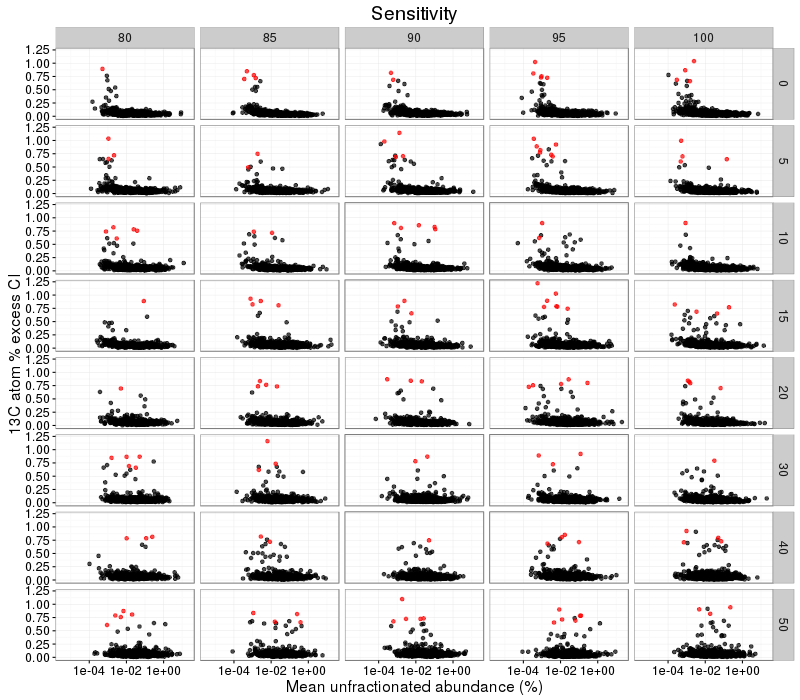

In [227]:
%%R -w 800 -h 700
as.Num = function(x) x %>% as.character %>% as.numeric

df.j %>% nrow %>% print
df.j.f = df.j %>%
    filter(true_incorporator==TRUE) %>%
    mutate(atom_fraction_excess = atom_fraction_excess %>% as.Num,
           atom_CI_low = atom_CI_low %>% as.Num,
           atom_CI_high = atom_CI_high %>% as.Num,
           pred_incorp = atom_CI_low > 0,
           pred_incorp = ifelse(is.na(pred_incorp), FALSE, pred_incorp),
           atom_CI = atom_CI_high - atom_CI_low,
           shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))
        
    
# plotting
ggplot(df.j.f, aes(mean_abund, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.7, color='red') +    
    scale_x_log10() +
    facet_grid(perm_perc ~ shared_perc) +
    labs(x='Mean unfractionated abundance (%)', 
         y='13C atom % excess CI',
         title='Sensitivity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

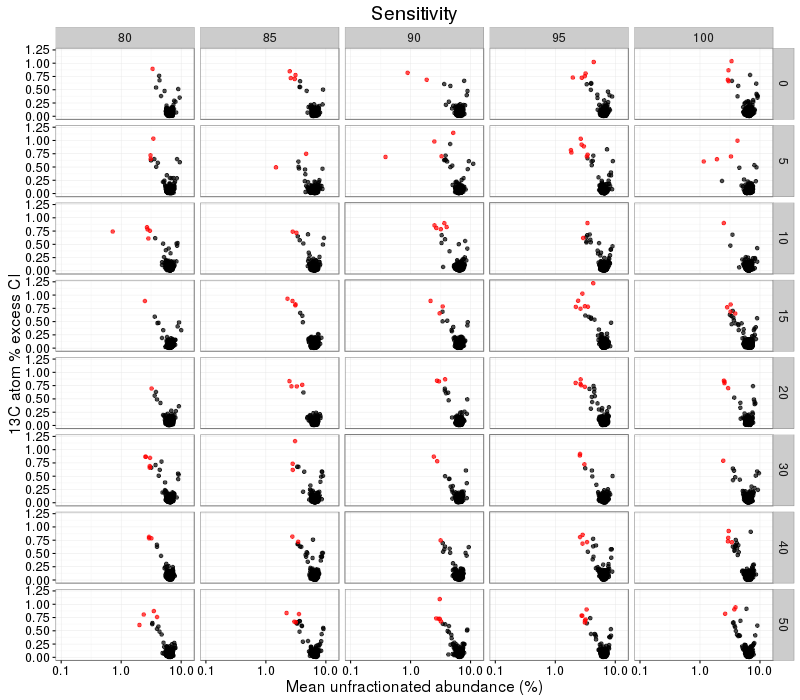

In [228]:
%%R -w 800 -h 700

# plotting
ggplot(df.j.f, aes(treatment_MW - control_MW, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.7, color='red') +    
    scale_x_log10() +
    facet_grid(perm_perc ~ shared_perc) +
    labs(x='Mean unfractionated abundance (%)', 
         y='13C atom % excess CI',
         title='Sensitivity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

[1] 441920


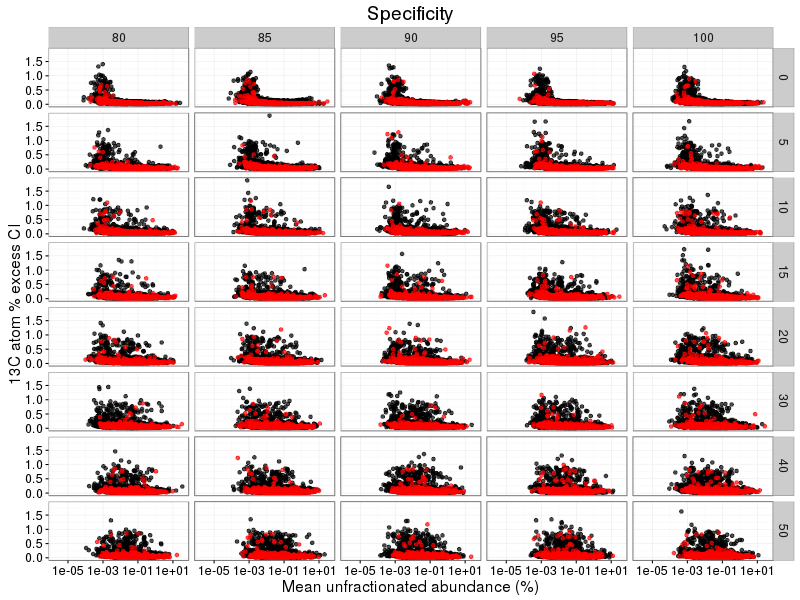

In [229]:
%%R -w 800 -h 600
as.Num = function(x) x %>% as.character %>% as.numeric

df.j %>% nrow %>% print
df.j.f = df.j %>%
    filter(true_incorporator==FALSE) %>%
    mutate(atom_fraction_excess = atom_fraction_excess %>% as.Num,
           atom_CI_low = atom_CI_low %>% as.Num,
           atom_CI_high = atom_CI_high %>% as.Num,
           pred_incorp = atom_CI_low > 0,
           pred_incorp = ifelse(is.na(pred_incorp), FALSE, pred_incorp),
           atom_CI = atom_CI_high - atom_CI_low,
           shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))
        
    
# plotting
ggplot(df.j.f, aes(mean_abund, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='red') +
    scale_x_log10() +
    facet_grid(perm_perc ~ shared_perc) +
    labs(x='Mean unfractionated abundance (%)', 
         y='13C atom % excess CI',
         title='Specificity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

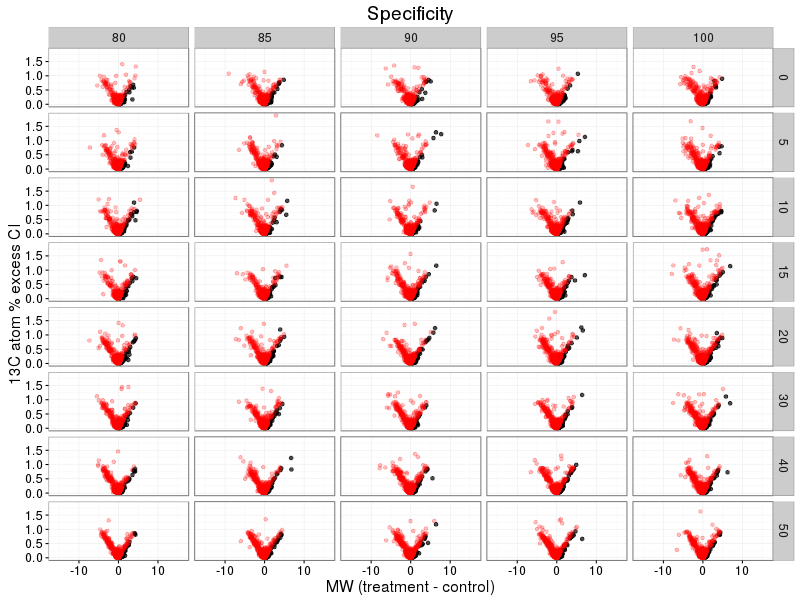

In [230]:
%%R -w 800 -h 600
    
# plotting
ggplot(df.j.f, aes(treatment_MW - control_MW, atom_CI)) +
    geom_point(data=df.j.f %>% filter(pred_incorp==TRUE), alpha=0.7, color='black') +
    geom_point(data=df.j.f %>% filter(pred_incorp==FALSE), alpha=0.25, color='red') +    
    facet_grid(perm_perc ~ shared_perc) +
    labs(x='MW (treatment - control)', 
         y='13C atom % excess CI',
         title='Specificity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### chk

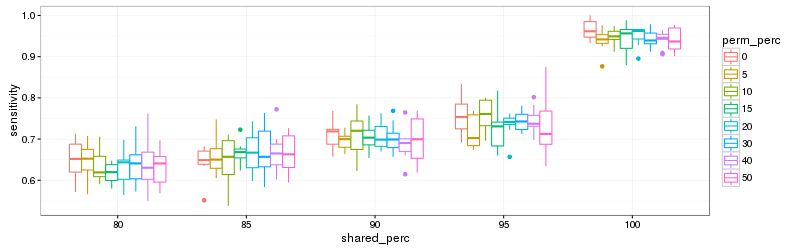

In [223]:
%%R -w 800 -h 250
# summarize
df.j.s = df.j %>% 
    mutate(atom_CI_low = atom_CI_low %>% as.Num,
           pred_incorp = atom_CI_low > 0,
           pred_incorp = ifelse(is.na(pred_incorp), 0, pred_incorp),
           FN = ifelse(pred_incorp==FALSE & true_incorporator==TRUE, 1, 0),
           TP = ifelse(pred_incorp==TRUE & true_incorporator==TRUE, 1, 0)) %>%
    group_by(shared_perc, perm_perc, rep) %>%
    summarize(n_FN = sum(FN),
              n_TP = sum(TP),
              n = n()) %>%
    ungroup() %>%
    mutate(sensitivity = n_TP / (n_FN + n_TP),
           shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))
    

# plotting
ggplot(df.j.s, aes(shared_perc, sensitivity, color=perm_perc)) +
    geom_boxplot() +
    theme_bw()

# Sandbox

In [182]:
%%R
F = '/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/1/qSIP-cMtx_data.txt'

df = read.delim(F, sep='\t') %>%
    mutate(FP = ifelse(incorp.known==FALSE & incorp.pred==TRUE, 1, 0)) %>%
    group_by(library) %>%
    summarize(n_FP = sum(FP)) %>%
    ungroup()

df %>% head

Source: local data frame [3 x 2]

  library  n_FP
    (int) (dbl)
1       2   183
2       4   183
3       6   183
